# “Embed, embed! There’s knocking at the gate.”
## Detecting Intertextuality with Embeddings and the Vectorian

<i>Bernhard Liebl & Manuel Burghardt <br>
    Computational Humanities Group, Leipzig University</i>

## Table of Contents

* [1. Introduction](#section_1)
    * [1.1 Enter: word embeddings](#section_1_1)
    * [1.2 Outline of the notebook](#section_1_2)
    * [1.3 Technical setup](#section_1_3)
* [2. Data and Tools](#section_2)
    * [2.1 Introducing the gold standard dataset](#section_2_1)
    * [2.2 Overview of different types of embeddings](#section_2_2)
    * [2.3 "Shapespeare in the Vectorian Age" – Meet the Vectorian framework](#section_2_3)
        * [2.3.1 Loading word embeddings](#section_2_3_1)
        * [2.3.2 Creating the session](#section_2_3_2)
* [3. Embeddings as a tool for intertextuality research](#section_3)
    * [3.1  Exploring word embeddings](#section_3_1)
        * [3.1.1 An introduction to word embeddings and token similarity](#section_3_1_1)
        * [3.1.2 Detecting Shakespearean intertextuality through word embeddings](#section_3_1_2)
    * [3.2 Exploring document embeddings](#section_3_2)
    * [3.3 Exploring word mappings: WSB vs. WMD](#section_3_3)
        * [3.3.1 Mapping quote queries to longer text documents](#section_3_3_1)
        * [3.3.2 Evaluation: Plotting the nDCG over the corpus](#section_3_3_2)
        * [3.3.3 Focussing on single queries](#section_3_3_3)
    * [3.4 The influence of different embeddings](#section_3_4)
* [4. Conclusion](#section_4)
* [5. Interactive searches with your own data](#section_5)
* [6. References](#section_6)


# 1. Introduction <a class="anchor" id="section_1"></a>

The detection of intertextual references in text corpora is a digital humanities topic that has gained a lot of attention in recent years (for instance Bamman & Crane, 2008; Burghardt et al., 2019; Büchler et al., 2013; Forstall et al., 2015; Scheirer et al., 2014). While intertextuality – from a literary studies perspective – describes the phenomenon of one text being present in another text (cf. Genette, 1993), the computational problem at hand is the task of text similarity detection (Bär et al., 2012), and more concretely, semantic similarity detection. 

In the following example of Shakespearean intertextuality, the words *bleed* and *leak* are semantically (and phonetically) similar, demonstrating that *Star Trek* here is quoting Shakespeare without any doubt: 

> Shylock: If you prick *us*, do *we* not **bleed**. <br>
(Shakespeare; The Merchant of Venice)

> Data: If you prick *me*, do *I* not **leak**. <br>
(Star Trek: The Next Generation; The Measure of a Man)

## 1.1 Enter: word embeddings <a class="anchor" id="section_1_1"></a>

Over the years, there have been various attempts for measuring semantic similarity, some of them knowledge-based (e.g. based on WordNet), others corpus-based, like LDA (Chandrasekaran & Vijay, 2021). The arrival of word embeddings (Mikolov et al., 2013) has changed the field considerably by introducing a new and fast way to tackle the notion of word meaning. On the one hand, word embeddings are building blocks that can be combined with a number of other methods, such as alignments, soft cosine or Word Mover's Distance, to implement some kind of sentence similarity (Manjavacas et al., 2019). On the other hand, the concept of embeddings can be extended to work on the sentence-level as well, which is a conceptually different approach (Wieting et al., 2016). 

We introduce the **<a href="https://github.com/poke1024/vectorian">Vectorian</a>** as a framework that allows researchers to try out different embedding-based methods for intertextuality detection. In contrast to previous versions of the Vectorian (Liebl & Burghardt, 2020a/b) as a mere web interface with a limited set of static parameters, we now present a clean and completely redesigned API that is showcased in an interactive Jupyter notebook. In this notebook, we first use the Vectorian to build queries where we plug in static word embeddings such as FastText (Mikolov et al., 2018) and GloVe (Pennington et al., 2014). We evaluate the influence of computing similarity through alignments such as Waterman-Smith-Beyer (WSB; Waterman et al., 1976) and two variants of Word Mover’s Distance (WMD; Kusner et al., 2015). We also investigate the performance of state-of-art sentence embeddings like Siamese BERT networks (Reimers & Gurevych, 2019) for the task - both on a document level (as document embeddings) and as contextual token embeddings. Overall, we find that WSB with fastText offers highly competitive performance. We find that POS tag-weighted WSB seems to further improve results a small subset of queries. Readers can upload their own data for performing search queries and try out additional vector space metrics such as p-norms or improved sqrt‐cosine similarity (Sohangir & Wang, 2017).

## 1.2 Outline of the notebook <a class="anchor" id="section_1_2"></a>

In the notebook, we will go through different examples of intertextuality to demonstrate and explain the implications of different embeddings and similarity measures. To achieve this we provide a small ground truth corpus of intertextual Shakespeare references that can be used for some controlled evaluation experiments. Our main goal is to provide an interactive environment, where researchers can test out different methods for text reuse and intertextuality detection. This notebook thus adds to a critical reflection of digital methods and can help to shed some light on their epistemological implications for the field of computational intertextuality detection. At the end of the notebook, researchers can also easily import their own data and investigate all the showcased methods for their specific texts. 

## 1.3 Technical setup <a class="anchor" id="section_1_3"></a>

We import a couple of helper functions for visualizations and various computations (`nbutils`), a wrapper to load our gold standard data (`gold`), and finally the Vectorian library (`vectorian`), through which we will perform searches and evaluations later on.

In `nbutils.initialize` we check whether there is a [bokeh server](https://docs.bokeh.org/en/latest/index.html) available. This typically *is* the case for local Jupyter installations, but is *not* the case for notebooks running on *mybinder*. In the latter case, the notebook has some limitations regarding interactivity.

In [1]:
import sys
sys.path.append("code")  # make "nbutils" and "code" importable

import nbutils, gold, vectorian
import ipywidgets as widgets
from ipywidgets import interact

nbutils.initialize("auto")

Loading BokehJS ...

# 2. Data and Tools <a class="anchor" id="section_2"></a>

## 2.1 Introducing the gold standard dataset <a class="anchor" id="section_2_1"></a>

In the following we use a collection of 100 short text snippets (=documents) that quote a total of 20 different Shakespeare phrases. All of these documents were derived from the [WordWeb IDEM portal](http://wordweb-idem.ch/about-us.html), where literary scholars collect intertextual references in a freely accessible database (Hohl et al., 2020). Each document quotes exactly one of the 20 phrases. For some phrases, e.g. "to be or not to be", there are more quoting documents than for others (see interactive overview of documents below). If there are multiple documents that quote the same phrase, we selected them in a way each of them does this in a different way. There are no verbatim quotes in the documents, but always more or less complex variations of the original phrase.

We use this collection of quote documents as a gold standard, to be able to assess how well different embeddings work for different types of quotes. 

In [2]:
gold_data = gold.Data("data/raw_data/gold.json")

Technically speaking, our gold standard consists of a number of `Patterns` that carry information where they re-occur in other contexts (see diagram below).

A `Pattern` consists of a specific phrase, e.g. "to be or not to be", and information on its `Source`, i.e. from which work it is derived from. In the example data for this notebook the `Source` of a `Pattern` is always a work by William Shakespeare.

Text reuse occurs as `Pattern` phrases occur in other works and contexts in more or less rephrased form. These re-occurences of the original `Pattern` phrase in other places than in the `Pattern`'s `Source` are modelled through the `Occurrence` class in our data. An `Occurrence` knows about a rephrasing of the original phrase and carries information where this rephrasing happened (again in form of a `Source`).

More specifically, the rephrasing information consists of the actual rephrased text (`phrase`) and the surrounding context in which this rephrasing occurs (`context`) at the new `Source`. Together these two elements (new phrase and its context) are termed `Evidence`.

![UML of gold standard data](miscellaneous/gold_uml.svg)

To give a specific example, the widget below shows the (re-)`Occurrence` of the Shakespeare `Pattern` phrase "to be or not to be" in a non-Shakespeare `Source` titled "The Phoenix". The `Evidence` connected to this (re-)`Occurence` consists of the `phrase` "to be named or not be named" (highlighted in bold below) and the `context` (the whole line by "Fidelio" in which this rephrasing is embedded).

The widget below can be used to browse all of the 20 quote patterns in the 100 associated documents.

In [3]:
nbutils.Browser(gold_data, "to be or not to be", "The Phoenix");

For a further exploration of the dataset, we also provide a visualization of the gold standard dataset, with `Patterns` indicated as blue circles and `Evidence` indicated as green circles. Matching evidence and patterns are connected via edges and each bouqet consists of one pattern and the matching instances of text reuse. Hovering the mouse over the nodes reveals their actual contents.

In [4]:
nbutils.plot_gold(gold_data)

## 2.2 Overview of different types of embeddings <a class="anchor" id="section_2_2"></a>

**Word embeddings** take up the linguistic concept of collocations. For each word in a corpus it is recorded with which other words it occurs. These collocation profiles are then represented as vectors. If, for example, two words (e.g. "car" and "truck") occur with very similar words (e.g. „wheels, drive, street, etc.“) then they would also have very similar word vectors, i.e. they would be semantically - or at least structurally - very similar.

There are now various established ways to compute embeddings for word similarity tasks. A first important distinction to be made is between *token* / *word* embeddings and *document* embeddings. While **token embeddings** model one embedding per token, **document embeddings** try to  map an entire document (i.e. a set of tokens) into one single embedding. There are two common ways to compute document embeddings. One way is to derive them from token embeddings, for instance by averaging those. More complex approaches train dedicated models that are optimized to produce good document embeddings.

This means that, all in all, we can distinguish three types of embeddings:

* original token embeddings
* document embeddings derived from token embeddings (e.g. by averaging them)
* document embeddings from dedicated models, such as <a href="https://www.sbert.net/">Sentence-BERT</a> (Reimers & Gurevych, 2019)

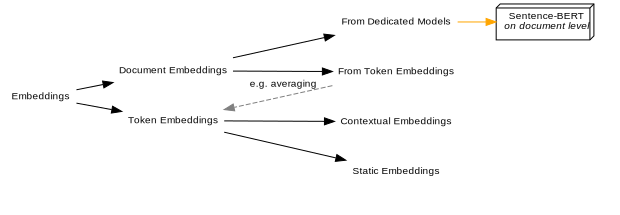

In [5]:
nbutils.plot_dot("miscellaneous/diagram_embeddings_1.dot")

When focussing only on token embeddings, there are various options, as the diagram below illustrates (as in the diagram above, orange arrows indicate specific embeddings used in this notebook). The most recent option are contextual token embeddings (also sometimes called *dynamic* embeddings), which will incorporate a specific token's context and can be obtained from architectures like <a href="https://jalammar.github.io/illustrated-bert/">ELMO or BERT</a>. Another option are static token embeddings, which map one token to one embedding, independent of its specific occurence in a text. For an overview of static and contextual embeddings, and their differences, see (Wang et al. 2020).

For static embeddings there is now a variety of established options like <a href="https://fasttext.cc/">fastText</a> or <a href="https://nlp.stanford.edu/projects/glove/">GloVe</a>. We can also combine embeddings or stack them (i.e. concatenate embedding vectors) to simply create new embeddings from existing ones.


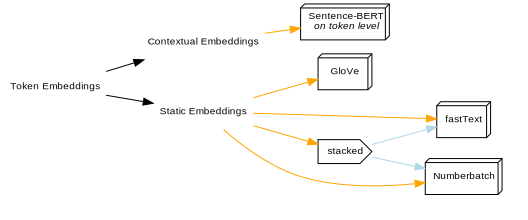

In [6]:
nbutils.plot_dot("miscellaneous/diagram_embeddings_2.dot")

In this notebook, we showcase the following four classes of embeddings:

* **Static token embeddings**: these operate on the token level. We experiment with <a href="https://nlp.stanford.edu/projects/glove/">GloVe</a> (Pennington et al. 2014), <a href="https://fasttext.cc/">fastText</a> (Mikolov et al., 2018) and <a href="https://github.com/commonsense/conceptnet-numberbatch">Numberbatch</a> (Speer et al, 2017). We use these three embeddings to compute token similarity and combine them with alignment algorithms (such as <a href="http://rna.informatik.uni-freiburg.de/Teaching/index.jsp?toolName=Waterman-Smith-Beyer">Waterman-Smith-Beyer</a>) to compute document similarity. We also investigate the effect of stacking two static embeddings (fastText and Numberbatch).
* **Contextual token embeddings**: these also operate on the token level, but embeddings can change according to a specific token instance's context. In this notebook we experiment with using such token embeddings from the <a href="https://www.sbert.net/">Sentence-BERT</a> model (Reimers & Gurevych, 2019).
* **Document embeddings derived from specially trained models**: document embeddings represent one document via one single embedding. We use document embeddings obtained from a BERT model. More specifically, we use a Siamese BERT model named Sentence-BERT, which is trained specifically for the semantic textual similarity (STS) task (Reimers & Gurevych, 2019).
* **Document embeddings derived from token embeddings**: We also experiment with averaging different kinds of token embeddings (static and contextual) to derive document embeddings.


## 2.3 "Shapespeare in the Vectorian Age" – Meet the Vectorian framework <a class="anchor" id="section_2_3"></a>

To conduct our actual investigations, we rely on a framework called the **<a href="https://github.com/poke1024/vectorian">Vectorian</a>**, which we first introduced in 2020 (Liebl & Burghardt, 2020a/b). Using highly optimized algorithms and data structures, the Vectorian enables fast searching over the gold standard data using a variety of approaches and strategies. 

In order to use the Vectorian, we need to map the gold standard concepts to Vectorian concepts as follows: From the gold standard, we want to gather all texts that contain some kind of text reuse. These texts reside in the `context` attribute of the `Evidence` instances (see Figure above). In the Vectorian, we then create `Documents` from those texts. A `Document` in Vectorian terminology is something we can perform a search on. `Documents` in the Vectorian are created using different kinds of `Importers` that perform necessary natural language processing tasks using an additional `NLP` class (see diagram below). Since this step can be very time-consuming, we precomputed this step and use the `Corpus` class to quickly load these preprocessed Documents into the notebook. For details about the full preprocessing, see `code/prepare_corpus.ipynb`. 



Using the loaded `Documents` and a set of `Embeddings` we want to work with, we can then create a `Session` that allows us to perform intertextuality searches. More details about
the technical architecture be build on in this notebook can be found in the [source code](https://github.com/poke1024/vectorian) and the [API Documentation](https://poke1024.github.io/vectorian/index.html) for the Vectorian.

### 2.3.1 Loading word embeddings <a class="anchor" id="section_2_3_1"></a>

In terms of static embeddings, we will work with <a href="https://nlp.stanford.edu/projects/glove/" target="_blank">GloVe</a>, <a href="https://fasttext.cc/docs/en/crawl-vectors.html" target="_blank">fastText</a> and <a href="https://github.com/commonsense/conceptnet-numberbatch" target="_blank">Numberbatch</a>. GloVe uses a form of matrix factorization on a global co-occurence matrix to compute embeddings for a finite set of predefined tokens (Pennington et al. 2014). In contrast, fastText training operates on  local context windows (Mikolov et al., 2018). In contrast to GloVe and the earlier word2vec, fastText additionally computes embeddings on character n-grams instead of tokens, which means there are no out-of-vocabulary tokens (Mikolov et al., 2018). Different to both GloVe and fastText, which only use data from a corpus, Numberbatch embeddings additionally incorporate information from a knowledge graph (Speer et al, 2017).

For reasons of limited RAM in the interactive Binder environment (and to limit download times), we use smaller or compressed versions of the official pretrained versions:

* for **<a href="https://nlp.stanford.edu/projects/glove/" target="_blank">GloVe</a>**, we use the official 50-dimensional version of the 6B variant
* for **<a href="https://fasttext.cc/docs/en/crawl-vectors.html" target="_blank">fastText</a>** we use a version that was trained on *Common Crawl* and *Wikipedia* using CBOW, and then compressed using the standard settings in https://github.com/avidale/compress-fasttext
* for **<a href="https://github.com/commonsense/conceptnet-numberbatch" target="_blank">Numberbatch</a>** we use version 19.08 that was reduced into a 50-dimension version using a standard PCA

We also use one **stacked embedding**, in which we combine fastText and Numberbatch. We will call this embedding `fasttext_numberbatch`.

Finally we will use a contextual embedding based on the Sentence-BERT architecture (Reimers & Gurevych, 2019). More specifically, this embedding will use the English <a href="https://huggingface.co/sentence-transformers/paraphrase-distilroberta-base-v1">paraphrase_distilroberta_base_v1</a> model. For simplicity, we refer to it as `sbert`.

To load these embeddings, we first need to instantiate a NLP parser that is capable of providing us with the desired Sentence-BERT embeddings. This NLP parser will also provide us with other standard NLP tasks such as POS tagging later on. Internally, we use <a href="https://spacy.io/">spaCy</a> to construct a suitable parser. `nlp.pipeline` will give the fully constructed NLP pipeline in case the reader is interested.

In [14]:
nlp = nbutils.make_nlp("en_paraphrase_distilroberta_base_v1")

Through `nlp` we can now create the desired `sbert` embedding (more specifically, a suitable class compatible with the Vectorian) as well as the other static embeddings we described earlier.

In [15]:
the_embeddings = nbutils.load_embeddings(nlp)
list(the_embeddings.keys())

['glove', 'fasttext', 'numberbatch', 'fasttext_numberbatch', 'sbert']

### 2.3.2 Creating the session <a class="anchor" id="section_2_3_2"></a>

The following code creates a `Session` in the Vectorian framework that will allow us to perform searches over the gold standard corpus using the desired embeddings:

In [22]:
session = vectorian.session.LabSession(
    vectorian.corpus.Corpus("data/processed_data/corpus", mutable=False),
    embeddings=the_embeddings.values())

Opening Corpus:   0%|          | 0/100 [00:00<?, ?it/s]

Preparing Documents:   0%|          | 0/100 [00:00<?, ?it/s]

The following line of code will speed up searches later in the notebook by loading all contextual embedding vectors into RAM.

In [23]:
session.cache_contextual_embeddings()

Loading Vectors:   0%|          | 0/100 [00:00<?, ?it/s]

# 3. Embeddings as a tool for intertextuality research <a class="anchor" id="section_3"></a>

## 3.1  Exploring word embeddings <a class="anchor" id="section_3_1"></a>

### 3.1.1 An introduction to word embeddings and token similarity <a class="anchor" id="section_3_1_1"></a>

Before we dive into the acutal intertextuality analyses, we first take a brief look at the inner workings of embeddings. Mathematically speaking, a word embedding is a vector **x** of dimension *n*, i.e. a vector consisting of *n* scalars.

$$\mathbf{x}=(x_1, x_2, ..., x_{n-1}, x_n)$$

For example, the compressed numberbatch embedding we use has *n*=50 and thus represents the word "coffee" with the following 50 scalar values:

In [13]:
widgets.GridBox(
    [
        widgets.Label(f"{x:.2f}")
        for x in session.word_vec(the_embeddings["numberbatch"], "coffee")
    ],
    layout=widgets.Layout(grid_template_columns="repeat(10, 50px)"),
)

GridBox(children=(Label(value='-0.05'), Label(value='-0.13'), Label(value='0.06'), Label(value='-0.09'), Label…

Since the above representation is difficult to understand, we visualize the values of

$$x_1, x_2, ..., x_{n-1}, x_n$$

through different colors. By default, all values are normalized by ||**x**||&#x2082;, i.e. the dot product of these values gives the cosine similarity.

In [14]:
@interact(
    embedding=widgets.Dropdown(
        options=[(k, v) for k, v in the_embeddings.items() if not v.is_contextual],
        value=the_embeddings["numberbatch"],
    ),
    normalize=True,
)
def plot(embedding, normalize):
    nbutils.plot_embedding_vectors_val(
        ["sail", "boat", "coffee", "tea", "guitar", "piano"],
        get_vec=lambda w: session.word_vec(embedding, w),
        normalize=normalize,
    )

interactive(children=(Dropdown(description='embedding', index=2, options=(('glove', <vectorian.embeddings.Word…

By looking at these color patterns, we can gain some intuitive understanding of why and how word embeddings are appropriate for word similarity calculations. For example, *sail* and *boat* both show a strong activation for dimension 27. Similarly, *guitar* and *piano* share similar values for dimension 24. The words *coffee* and *tea* also share some similar patterns for dimension 2 and dimension 49, which also set them apart from the other four words.

A common approach to compute the similarity between two word vectors **u** and **v** in this kind of high-dimensional vector spaces is to compute the cosine of the angle &theta; between the vectors, which is called **cosine similarity**:

$$cos \theta = \frac{\mathbf{u} \cdot \mathbf{v}}{||\mathbf{u}||_2 ||\mathbf{v}||_2} = \frac{\sum_1^n \mathbf{u}_i \mathbf{v}_i}{\sqrt{\sum_1^n \mathbf{u}_i^2} \sqrt{\sum_1^n \mathbf{v}_i^2}} = \sum_1^n \left( \frac{\mathbf{u}}{||\mathbf{u}||_2} \right)_i \left( \frac{\mathbf{v}}{||\mathbf{v}||_2} \right)_i$$

A large positive value (i.e. a small &theta; between **u** and **v**) indicates higher similarity, whereas a small or even negative value (i.e. a large &theta;) indicates lower similarity. For a discussion of issues with this notion of similarity, see Faruqui et al. (2016).

The visualization below encodes

$$\left( \frac{\mathbf{u}}{||\mathbf{u}||_2} \right)_i \left( \frac{\mathbf{v}}{||\mathbf{v}||_2} \right)_i$$

for different i, 1 &le; i &le; n, through colors to illustrate how different components contribute to the cosine similarity for two words. Brighter colors (orange/yellow) indicate dimensions with higher values.

In [15]:
@interact(
    embedding=widgets.Dropdown(
        options=[(k, v) for k, v in the_embeddings.items() if not v.is_contextual],
        value=the_embeddings["numberbatch"],
    )
)
def plot(embedding):
    nbutils.plot_embedding_vectors_mul(
        [("sail", "boat"), ("coffee", "tea"), ("guitar", "piano")],
        get_vec=lambda w: session.word_vec(embedding, w),
    )

interactive(children=(Dropdown(description='embedding', index=2, options=(('glove', <vectorian.embeddings.Word…

A comparable investigation of fastText shows similar spots of positive dimensions. The plot here is somewhat more complex due to the higher number of dimensions (*n* = 300).

In [16]:
@interact(
    embedding=widgets.Dropdown(
        options=[(k, v) for k, v in the_embeddings.items() if not v.is_contextual],
        value=the_embeddings["fasttext"],
    )
)
def plot(embedding):
    nbutils.plot_embedding_vectors_mul(
        [("sail", "boat"), ("coffee", "tea"), ("guitar", "piano")],
        get_vec=lambda w: session.word_vec(embedding, w),
    )

interactive(children=(Dropdown(description='embedding', index=1, options=(('glove', <vectorian.embeddings.Word…

Computing the overall cosine similarity for two words is mathematically equivalent to summing up the terms in the diagram above. The overall similarity between *guitar* and *piano* is approx. 68% with the fastText embedding we use. For *guitar* and *coffee* it is significantly lower with a similarity of approx. 20%.


In [17]:
from vectorian.metrics import TokenSimilarity, CosineSimilarity

token_sim = TokenSimilarity(the_embeddings["fasttext"], CosineSimilarity())

[session.similarity(token_sim, "guitar", x) for x in ["piano", "coffee"]]

[0.68097234, 0.19857687]

To compute the similarity between tokens of a contextual embedding, we need to reference the actual token instances within a text document.

In [18]:
token_sim = TokenSimilarity(the_embeddings["sbert"], CosineSimilarity())

a = list(session.documents[0].spans(session.partition("document")))[0][2]
b = list(session.documents[6].spans(session.partition("document")))[0][5]
[a.text, b.text, session.similarity(token_sim, a, b)]

['By', 'thou', 0.32798317]

### 3.1.2 Detecting Shakespearean intertextuality through word embeddings <a class="anchor" id="section_3_1_2"></a>

We explore the usefulness of embeddings and token similarity with the gold standard dataset that was introduced earlier. In the following example the pattern "the rest is silence" is quoted as "the rest is all but wind". While the syntactic structure is mirrored between pattern and occurrence, the term "silence" is replaced with "all but wind". If we focus on nouns only, we can expect "silence" and "wind" to be semantically related - at least to a certain degree.

In [19]:
vis = nbutils.TokenSimPlotterFactory(session, nlp, gold_data)

In [20]:
plotter1 = vis.make("rest is silence", "Fig for Fortune")

In the following, we inspect the cosine similarity of the token "silence" with other tokens in the document's ("A Fig of Fortune, 1596") context for three different embedding models.It becomes clear that for all three embeddings there is a strong connection between "silence" and "wind". The cosine similarity is particularly high with the Numberbatch model. Nevertheless, the absolute value of 0.3 for Numberbatch is still in a rather low range. Interestingly, GloVe associates "silence" with "action", which can be understood as quite the opposite of silence. The phenomenon that embeddings sometimes cluster opposites is a common observation and can be a problem when trying to distinguish between synonyms and antonyms.

In [22]:
plotter1("silence")

In an example for the pattern "sea of troubles", we see that the word "sea" in one document is paraphrased as "waves", and "troubles" is substituted by "troublesome". If we take a closer look at the cosine similarities of the tokens "sea" and "troubles" with all the other tokens in the document's context, we see that they are – expectedly – rather high.

In [23]:
plotter2 = vis.make("sea of troubles", "Book of Common Prayer")

In [25]:
plotter2("sea")

In [27]:
plotter2("troubles")

It is also interesting to investigate how out-of-vocabulary words like "troublesomest" produce zero similarities with standard key-value embeddings, whereas fastText is still able to produce a vector thanks to subword information.

In [29]:
plotter2("troublesomest")

## 3.2 Exploring document embeddings <a class="anchor" id="section_3_2"></a>

Next, we consider the representation of each document with a single embedding to gain an understanding of how different embedding strategies relate to document similarity. We will later return to individual token embeddings.

For this purpose, we will use the two strategies already mentioned for computing document embeddings:

* averaging over token embeddings
* computing document embeddings through a dedicated model

In order to achieve the latter, we compute document embeddings using Sentence-BERT. The `CachedPartitionEncoder` in the following code will encode and cache the document embeddings.

In [30]:
from vectorian.embeddings import CachedPartitionEncoder, SpanEncoder

# create an encoder that basically calls nlp(t).vector
sbert_encoder = CachedPartitionEncoder(
    SpanEncoder(lambda texts: [nlp(t).vector for t in texts])
)

# compute encodings and/or save cached data
sbert_encoder.try_load("data/processed_data/doc_embeddings")
sbert_encoder.cache(session.documents, session.partition("document"))
sbert_encoder.save("data/processed_data/doc_embeddings")

# extract name of encoder for later use
sbert_encoder_name = nlp.meta["name"]

We first present a strategy that creates embeddings for a document using the Sentence-BERT encoder. 

In [32]:
embedder = nbutils.DocEmbedder(
    session=session,
    nlp=nlp,
    doc_encoders={sbert_encoder_name: sbert_encoder},
    encoder="paraphrase_distilroberta",
)
embedder.display()

Similar to the investigation of token embedding values, we now look at the feature dimensions of the document embeddings. In the following plot we observe that the pattern "an old man is twice a child" and the corresponding text reuses from the gold standard (i.e. the true positives) show some salient contribution around dimensions 25 and 300 (see the 5 upper rows). When comparing the same pattern with non-matching text reuse occurences from the "go, by Saint Hieronimo" pattern on the other hand (see the 5 lower rows), there is less activation in these areas. Therefore these areas seem to offer some good features to differentiate the matching of a pattern with the correct occurrences.

In [33]:
bars = nbutils.DocEmbeddingBars(embedder, session, gold_data)
bars.plot("an old man is twice a child", "Saint Hieronimo")

interactive(children=(Dropdown(description='pattern', index=4, layout=Layout(width='max-content'), options=('t…

Instead of focusing on only one pattern, we now look at a plot of the embeddings of all documents in our gold standard data. The plot uses a dimensionality reduction technique known as t-Distributed Stochastic Neighbor Embedding (t-SNE) and allows us to reduce multiple dimensions to just two dimensions.

In [35]:
doc_embedding_explorer = nbutils.DocEmbeddingExplorer(
    session=session,
    nlp=nlp,
    gold=gold_data,
    doc_encoders={sbert_encoder_name: sbert_encoder},
)

doc_embedding_explorer.plot(
    [
        {
            "encoder": "paraphrase_distilroberta",
            "locator": ("fixed", "carry coals")
        },
        {
            "encoder": "paraphrase_distilroberta",
            "locator": ("fixed", "an old man is twice"),
        },
    ]
)

pass

In the t-SNE visualization above, the dots represent documents and the colors represent the query that results in this document in our gold standard (more details on the underlying documents are shown when hovering the mouse cursor over the nodes). Dots that are close to each other indicate that the underlying documents share a certain similarity. Nearby dots of the same color indicate that the embedding tends to cluster documents similar to our gold standard.

In the left plot, we searched for the phrase "we will not carry coals" (visualized as large yellow circle with a cross). The plot shows that the query is in fact part of a document cluster (smaller green-yellow circles) that contains a variation of that phrase. Similarly, on the right we see that the phrase "an old man is twice a child" clusters with the actual (green) documents we associate with it in our gold standard.

For these phrases and documents, the `paraphrase_distilroberta` model automatically produces a document embedding that actually recognizes and separates inherent structures.

In the plot above we looked at the document embedding produced by a **token-based** embedding. This has the advantage that we can actually look at token embeddings that make up the document embedding (through averaging), which we will do in the following plot. On the right side, we see a t-SNE plot of all the token embeddings that occur in the documents that are selected on the left. This visualization makes more transparent why certain documents on the left are clustered to be similar.

In [37]:
doc_embedding_explorer.plot(
    [
        {
            "encoder": "numberbatch",
            "selection": [
                "ww_32c26a7909c83bda",
                "ww_b5b8083a6a1282bc",
                "ww_9a6cb20b0b157545",
                "ww_a6f4b0e3428ad510",
                "ww_8e68a517bc3ecceb",
            ],
        }
    ]
)

pass

The red circles on the left represent contexts that match the phrase "a horse, a horse, my kingdom for a horse". When we look at the token embeddings in the right plot (that includes other documents as well), we  see that a group is formed due to word embeddings that cluster around "horse", but we also see a cluster around "boat", "sail" and "river" on the left. In fact document 1 contains "muscle boat", document 2 contains "To swim the river villain", and document 3 contains "A boat, a boat". We see that this kind of unsupervised document clustering groups items due to inherent qualities that might not actually match the initial query criteria.

Custom token embedding plots can be generated by selecting different documents from the left plot (drag the mouse to lasso).

## 3.3 Exploring word mappings: WSB vs. WMD <a class="anchor" id="section_3_3"></a>

So far, we have experimented with different token embeddings and seen how similarity comparison can be implemented for single tokens. However, for the detection of intertextual references it is necessary to compare longer token sequences with each other. The problem here is to identify the right segment in the target text, because a quotation like "to be or not to be" will occur as a local phenomenon, only at a certain position in a document. The rest of the document will likely be sentences that do not match with the quote phrase at all. To identify the segment where a potential quote occurs, there are different approaches. 

One popular class of techniques are sequence alignment algorithms as well as adjacent approaches like Dynamic Time Warping, see Kruskal (1983). In this section, we introduce the **<a href="http://rna.informatik.uni-freiburg.de/Teaching/index.jsp?toolName=Waterman-Smith-Beyer" target="_blank">Waterman-Smith-Beyer</a> (WSB)** algorithm, which produces optimal local alignments and provides a general (e.g. non-affine) cost function (Waterman, Smith & Beyer, 1974). Other commonly used global alignment algorithms - such as <a href="http://rna.informatik.uni-freiburg.de/Teaching/index.jsp?toolName=Smith-Waterman" target="_blank">Smith-Waterman</a> and <a href="http://rna.informatik.uni-freiburg.de/Teaching/index.jsp?toolName=Gotoh" target="_blank">Gotoh</a> - can be regarded as special cases of WSB. In comparison to the popular Needleman-Wunsch global alignment algorithm, WSB produces local alignments. In contrast to classic formulations of WSB - which often use a fixed substitution cost - we use the word distance from word embeddings to compute the substitution penalty for specific pairs of words.

Another approach to compute a measure of similarity between bags of words is the so-called **<a href="https://nbviewer.jupyter.org/github/vene/vene.github.io/blob/pelican/content/blog/word-movers-distance-in-python.ipynb" target="_blank">Word Mover's Distance</a>** introduced by Kusner et al. (2015). The main idea is computing similarity through finding the optimal solution of a transportation problem between words.

In the following, we will actually experiment with two variants of the WMD. In addition to the classic WMD, where a transportation problem is solved over the normalized bag of words (nbow) vector, we also introduce a new variant of WMD. In this new variant, we keep the bag of words (bow) unnormalized, i.e. we pose the transportation problem on absolute word occurrence counts.

Note: document embeddings do not need any of the above techniques, as they embed documents into a vector space in a way that queries and target documents that share similar features are close to each other in that space.

### 3.3.1 Mapping quote queries to longer text documents <a class="anchor" id="section_3_3_1"></a>

In [42]:
def make_index_builder(**kwargs):
    return nbutils.InteractiveIndexBuilder(
        session, nlp, partition_encoders={sbert_encoder_name: sbert_encoder}, **kwargs
    )

In [43]:
index_builder = make_index_builder()
index_builder

What can be seen above is the description of a search strategy that we will employ in the following sections of this notebook. By switching to the "Edit" part, it is possible to explore the settings in more detail and even change them to something completely different. Note that various parameters in the "Edit" GUI - e.g. mixing of embeddings - are beyond the scope of this notebook. For for more details see Liebl & Burghardt (2020a/b).

Example: For the pattern "to be or not to be" we find the following top matches ("to be named or not to be named"), with a similarity score of 96.6%. By increasing the n value we can always display more ranked results.

In [44]:
gold_data.patterns[0].phrase

'to be or not to be'

In [45]:
index_builder.build_index().find("old men have crotchet", n=1)

### 3.3.2 Evaluation: Plotting the nDCG over the corpus <a class="anchor" id="section_3_3_2"></a>

In the following we will systematically evaluate different strategies for identifying intertextuality in our gold standard data. We investigate WSB and the two variants of WMD (bow vs. nbow) in combination with the fastText embedding. As another variant we evaluate the performance of Sentence-BERT document embeddings. The evaluation metric is **normalized discounted cumulative gain** [(nDCG)](https://en.wikipedia.org/wiki/Discounted_cumulative_gain) (also see Liebl & Burghardt, 2020b).

Each specific query (on a *phrase*) operates on a corpus consisting of a set of documents

$D = d_1, ..., d_n$

In our case n = 100. Furthermore, we call the set of relevant document for this query R, with

$R = r_1, ..., r_k$

In other words, R models the ground truth as the results we regard as optimal for a specific query. In our case R is the set of *occurence*s stored for the queried *phrase* in our ground truth.

If the documents we actually retrieve are numbered

$x_1, ..., x_n$

in order of their score (highest first), then the nDCG for that specific retrieval is defined as follows:

$$
rel_i=\begin{cases}
    1 & \text{if } x_i \in R,\\
    0 & \text{if } x_i \notin R,
  \end{cases}, \hspace{1em}
DCG_n=\sum_{i=1}^{n}\frac{rel_i}{log_2 (i+1)}, \hspace{1em}
IDCG_k=\sum_{i=1}^{k}\frac{1}{log_2 (i+1)}, \hspace{1em}
nDCG=\frac{DCG_n}{IDCG_k}
$$

In the summary below you will find more detailed descriptions of the search strategies that will be evaluated in the following. By using "Edit", it is possible to change these settings to something else (a rerun of the following sections of the notebook would then be necessary).

In [46]:
import collections
import ipywidgets as widgets

# define 4 different search stratgies via make_index_builder 
index_builders = collections.OrderedDict(
    {
        "wsb": make_index_builder(
            strategy="Alignment",
            strategy_options={
                "alignment": vectorian.alignment.LocalAlignment(
                    gap={
                        "s": vectorian.alignment.smooth_gap_cost(5),
                        "t": vectorian.alignment.smooth_gap_cost(5)
                    }
                )
            },
        ),
        "wmd nbow": make_index_builder(
            strategy="Alignment",
            strategy_options={
                "alignment": vectorian.alignment.WordMoversDistance.wmd("nbow")
            },
        ),
        "wmd bow": make_index_builder(
            strategy="Alignment",
            strategy_options={
                "alignment": vectorian.alignment.WordMoversDistance.wmd("bow")
            },
        ),
        "doc embedding": make_index_builder(strategy="Partition Embedding"),
    }
)

# present UI of various options that allows for editing
accordion = widgets.Accordion(children=[x.displayable for x in index_builders.values()])
for i, k in enumerate(index_builders.keys()):
    accordion.set_title(i, k)
accordion

Accordion(children=(Tab(children=(HTML(value='<span style="line-height:normal;"><p>Partition similarity is com…

With the following command we will get an overview of the quality of the results we obtain when using the index configures with `index_builder` by computing the nDCG over the 20 queries in our gold standard with regard to the known optimal results (this may take a few seconds).

In [47]:
nbutils.plot_ndcgs(
    gold_data, dict((k, v.build_index()) for k, v in index_builders.items())
);

  0%|          | 0/80 [00:00<?, ?it/s]

We see that some queries obtain 100%, i.e. the top results match the optimal ones given in our gold standard. We see that Waterman-Smith-Beyer (WSB) tends to perform a little better than Word Mover's Distance (WMD), with the exception of "though this be madness...", where WMD outperforms WSB. In general the Vectorian modification of WMD, which does not use nbow, performs better than the original description of WMD. The one exception here is "livers white as milk".

One advantage of WSB over the full WMD variants is its easy interpretability. WSB produces an alignment that relates one document token to at most one query token. For WMD, this assumption often breaks down, which makes the results harder to understand. We use this characteristic of WSB in the following section to illustrate which mappings actually occur.

### 3.3.3 Focussing on single queries <a class="anchor" id="section_3_3_3"></a>

We now investigate some queries, for which the performance for WSB is bad, to get a better understanding for why our search fails to obtain the optimal (true positive) results at the top of the result list.

In [48]:
index_builder = make_index_builder()
index_builder

We turn to the query with the lowest score ("though this be madness, yet there is a method in it") in the previous evaluation, and look at its results in some more detail.

In [49]:
plot_a = nbutils.plot_results(
    gold_data, index_builder.build_index(), "though this be madness", rank=7
)

The best match obtained here (red bar on rank 7) is anchored on two word matches, namely `madness` (a 100% match) and `methods` (a 72% match). The other words are quite different and there is no good alignment.

In [50]:
plot_b = nbutils.plot_results(
    gold_data, index_builder.build_index(), "though this be madness", rank=3
)

Above we see the rank 3 result from the same query, which is a false positive - i.e. our search claims it is a better result than the one we saw before, but in fact this result is not relevant according to our gold standard. If we analyze why this result gets such a high score nonetheless, we see that "is" and "in" both contribute 100% scores. In contrast to the scores before, 100% for "madness" and 72% for "methods", this partially explains the higher overall score (if we assume for now that the contributions from the other tokens are somewhat similar).

We will now try to understand why the true positive results are ranked rather low. To find a solution for this issue, we will be looking at the composition of scores for each result we obtain for this query:

In [51]:
nbutils.vis_token_scores(
    plot_b.matches[:50],
    highlight={"token": ["madness", "method"], "rank": [6, 20, 35, 45]},
)

interactive(children=(Checkbox(value=False, description='indicate_gap_penalty'), Output()), _dom_classes=('wid…

<function nbutils.vis_token_scores.<locals>.plot(indicate_gap_penalty)>

The true positive results are marked with black triangles. We see that our current search strategy isn't doing a very good job of ranking them highly. Looking at the score composition of the relevant results, we can identify two distinct features: all relevant results show a rather large contribution of either "madness" (look at rank 6 and rank 35, for example) and/or a rather large contribution of "method" (ranks 45 and 6). However, these contributions do not lead to higher ranks necessarily, since other words such as "is", "this" and "though" score higher for other results: for example, look at the contribution of "in" for rank 1.

In the plot below, we visualize this observation using ranks 1, 6 and 35. Comparing the rank 1 result on the left - which is a false positive - with the two relevant results on the right, we see that "in", "through" and "is" make up for large parts of the score for rank 1, whereas "madness" is a considerable factor for the two relevant matches. Unfortunately, this contribution is not sufficient to bring these results to higher ranks.

In [52]:
@widgets.interact(plot_as=widgets.ToggleButtons(options=["bar", "pie"], value="pie"))
def plot(plot_as):
    nbutils.vis_token_scores(
        plot_b.matches, kind=plot_as, ranks=[1, 6, 35], plot_width=800
    )

interactive(children=(ToggleButtons(description='plot_as', index=1, options=('bar', 'pie'), value='pie'), Outp…

The distributions of score contributions we just observed are the motivation for our approach to tag-weighted alignments as they are described in Liebl & Burghardt (2020a/b). Nagoudi and Schwab (2017) used a similar idea of POS tag-weighting for computing sentence similarity, but did not combine it with alignments.

We now demonstrate (POS) tag-weighted alignments, by using a tag-weighted alignment that will weight nouns like "madness" and "method" 3 times higher than other word types. "NN" is a Penn Treebank tag and identifies singular nouns.

In [53]:
tag_weighted_index_builder = make_index_builder(
    strategy="Tag-Weighted Alignment", strategy_options={"tag_weights": {"NN": 3}}
)
tag_weighted_index_builder

In [54]:
nbutils.plot_results(
    gold_data, tag_weighted_index_builder.build_index(), "though this be madness"
)

Tag-weighting moves the correct results far to the top, namely to ranks 1, 2, 4 and 6. By increasing the NN weight to 5, it is possible to promote the true positive on rank 73 to rank 15. This is a bit of an extreme measure though and we will not investigate it further here. Instead we investigate how the weighting affects the other queries. Therefore, we re-run the nDCG computation and compare it against unweighted WSB.

In [55]:
index_builder_unweighted = make_index_builder()
index_builder_unweighted

In [56]:
import importlib
importlib.reload(nbutils)

tw_data = nbutils.plot_ndcgs(
    gold_data,
    {
        "wsb_unweighted": index_builder_unweighted.build_index(),
        "wsb_weighted": tag_weighted_index_builder.build_index(),
    },
)

  0%|          | 0/40 [00:00<?, ?it/s]

The evaluation shows that even though there is an improvement in the mean nDCG when employing POS tag weighting for the corpus, the effect vanishes when computing the median. When looking at the results in detail, we see that the better overall mean value can be tracked down to an improvement in only three queries (see top 3 entries in column *better* below). In fact, the first query is the one we used as rationale for the whole design. More research is needed to understand if tag weighted alignment might in general benefit some subset of queries.

In [57]:
nbutils.eval_strategies(tw_data, gold_data)

## 3.4 The influence of different embeddings <a class="anchor" id="section_3_4"></a>

While we have varied the similarity metrics in the previous example, we will now look into the effect that different embeddings might have on the results. The caveat here is that we are using compressed embeddings, i.e. we would need to verify these results with uncompressed embeddings. Still, the performance of compressed fastText seems very solid.

In [58]:
index_builders = {}

# for each embedding, define a search strategy based on tag-weighted alignments
for e in the_embeddings.values():
    index_builders[e.name] = make_index_builder(
        strategy="Tag-Weighted Alignment",
        strategy_options={"tag_weights": {"NN": 3}, "similarity": {"embedding": e}},
    )

# present an UI to interactively edit these search strategies
accordion = widgets.Accordion(children=[x.displayable for x in index_builders.values()])
for i, k in enumerate(index_builders.keys()):
    accordion.set_title(i, k)
accordion

Accordion(children=(Tab(children=(HTML(value='<span style="line-height:normal;"><p>Partition similarity is com…

In [59]:
nbutils.plot_ndcgs(
    gold_data, dict((k, v.build_index()) for k, v in index_builders.items())
);

  0%|          | 0/100 [00:00<?, ?it/s]

Some observations to be made here:
* In a few queries ("llo, ho, ho my lord", "frailty, thy name is woman", "hell itself should gape"), GloVe gives slightly better results than fastText, but this cannot be generalized to the overall performance.

* For some queries ("I do bear a brain.", "O all you host of heaven!") the embedding does not seem to matter at all.

* A real competitor for fastText are contextual embeddings from Sentence-BERT - however, these are much more expensive in terms of computation time, storage space and code complexity.

# 4. Conclusion <a class="anchor" id="section_4"></a>

In this interactive notebook we have demonstrated how different types of word embeddings can be used to detect intertextual phenomena in a semi-automatic way. We also provide a basic ground truth dataset of 100 short documents that contain 20 different quotes from Shakespeare's plays. This setup enables us to investigate the inner workings of different embeddings and to evaluate their suitability for the case of Shakespearean intertextuality. 

The following main findings – that also open up perspectives for future research – were obtained from this evaluation study:

1. POS tag-weighted alignments achieve the highest overall mean nDCG for our specific data, however this is not true for the median nDCG. Since tag-weighting does seem to improve the results of a very small subset of queries considerably, but does not improve the median performance, our future work will focus on better understanding the structure of queries and the role of outliers.

2. Document embeddings also show a strong performance. Their special appeal lies in easy use (assuming a pretrained model), as they do not rely on additional WSB or WMD mappings. 

3. When using WMD on short texts, our bow variant outperforms the original nbow variant by Kusner et al. (2015) by quite a margin. Further research must show whether these findings also hold for longer documents and how they evaluate when compared to optimized variants like RWMD (Kusner et al., 2015) and other variants (Werner & Laber, 2020).

4. In terms of embeddings, compressed fastText embeddings clearly outperform compressed GloVe and Numberbatch embeddings in our evaluations. Since we used low-dimensional embeddings for this notebook, these results are only a first hint and need to be verified through the use of full (high-dimensional) embbeddings. Contextual token embeddings extracted from Sentence-BERT provide a similar performance as fastText - however in terms of computation time and memory they are way more complex. All in all, our evaluation seems to highlight the solid performance of fastText.

While we were able to gather some interesting insights for the specific use case of Shakespearean intertextuality, the main goal of this notebook is to provide an interactive platform that enables other researchers to investigate other parameter combinations as well. The code blocks and widgets above offer many ways to play around with the settings and explore their effects on the ground truth data. 

More importantly, researchers can also import their own (English language) data to the notebook and experiment with all of the funtions and parameters that are part of the [Vectorian API](https://github.com/poke1024/vectorian-2021). We hope this notebook provides a low-threshold access to the toolbox of embeddings for other researchers in the field of intertextuality studies and thus adds to a critical reflection of these new methods.

# 5. Interactive searches with your own data <a class="anchor" id="section_5"></a>

First specify the text documents you want to search through the upload widget seen below. Note that it expects plain text files with a `.txt` extension. The upload widget is provided through a helper class called `CustomSearch`. Note that we provide this helper class with information about the embeddings we want to employ for searching.

A good source for obtaining some public domain plain text files to search in for this demo is <a href="https://wikisource.org">wikisource.org</a>. For example, you can <a href="https://ws-export.wmcloud.org/?lang=en&title=The_Origin_of_Species_(1872)&format=txt">download Charles Darwin's "The Origin of Species" via wikisource</a>. To download other titles, you need to enter the exact name identifier in wikisource. Always make sure that you are getting the plain text format.

In [88]:
search = nbutils.CustomSearch(
    [the_embeddings[x] for x in ["numberbatch", "fasttext"]])
search

FileUpload(value={}, accept='.txt', description='Add Corpus Text Files', layout=Layout(width='50%'), multiple=…

From the file or files stored in the upload widget above, we now build a Vectorian session. For this, we need an `nlp` instance for importing the text documents. Depending on the size and number of documents, the initial processing can take some time.

Once processing has finished, you are presented the full interactive search interface the Vectorian offers (we have hidden it so far and focussed on a subset). Note that in contrast to our experiments earlier, we do not search on the *document* level by default, but rather the *sentence* level - i.e. we split each document into sentences and then search on each sentence. You can change this in the "Partition" dropdown.

Use the "Query" edit field and the "Search" button to perform searches.

In [87]:
search.interact(nlp)

# 6. References
 <a class="anchor" id="section_6"></a>

Bamman, David & Crane, Gregory (2008). The logic and discovery of textual allusion. In Proceedings of the 2008 LREC Workshop on Language Technology for Cultural Heritage Data.

Bär, Daniel, Zesch, Torsten & Gurevych, Iryna (2012). Text reuse detection using a composition of text similarity measures. In Proceedings of COLING 2012, p. 167–184.

Büchler, Marco, Geßner, Annette, Berti, Monica & Eckart, Thomas (2013). Measuring the influence of a work by text re-use. Bulletin of the Institute of Classical Studies. Supplement, p. 63–79.

Burghardt, Manuel, Meyer, Selina, Schmidtbauer, Stephanie & Molz, Johannes (2019). “The Bard meets the Doctor” – Computergestützte Identifikation intertextueller Shakespearebezüge in der Science Fiction-Serie Dr. Who. Book of Abstracts, DHd.

Chandrasekaran, Dhivya & Mago, Vijay (2021). Evolution of Semantic Similarity – A Survey. ACM Computing Surveys (CSUR), 54(2), p. 1-37.

Faruqui, Manaal, Tsvetkov, Yulia, Rastogi, Pushpendre & Dyer, Chris (2016). Problems With Evaluation of Word Embeddings Using Word Similarity Tasks. In Proceedings of the 1st Workshop on Evaluating Vector-Space Representations for NLP, p. 30-35.

Forstall, Christopher, Coffee, Neil, Buck, Thomas, Roache, Katherine & Jacobson, Sarah (2015). Modeling the scholars: Detecting intertextuality through enhanced word-level n-gram matching. Digital Scholarship in the Humanities, 30(4), p. 503–515.

Genette, Gérard (1993). Palimpseste. Die Literatur auf zweiter Stufe. Suhrkamp.

Hohl-Trillini, Regula & Burghardt, Manuel & Molz, Johannes & Pichler, Alex & Reiter, Nils & Sulzbacher, Ben & Nantke, Julia (2020). "Intertextualität in literarischen Texten und darüber hinaus." Book of Abstracts, DHd 2020, Paderborn.

Kusner, Matt, Sun, Yu, Kolkin, Nicholas & Weinberger, Kilian (2015). From word embeddings to document distances. In International conference on machine learning, p. 957-966.

Liebl, Bernhard & Burghardt, Manuel (2020a). „The Vectorian“ – Eine parametrisierbare Suchmaschine für intertextuelle Referenzen. Book of Abstracts, DHd 2020, Paderborn.

Liebl, Bernhard & Burghardt, Manuel (2020b). “Shakespeare in The Vectorian Age” – An Evaluation of Different Word Embeddings and NLP Parameters for the Detection of Shakespeare Quotes”. Proceedings of the 4th Joint SIGHUM Workshop on Computational Linguistics for Cultural Heritage, Social Sciences, Humanities and Literature (LateCH), co-located with COLING’2020.

Manjavacas, Enrique, Long, Brian & Kestemont, Mike (2019). On the feasibility of automated detection of allusive text reuse. Proceedings of the 3rd Joint SIGHUM Workshop on Computational Linguistics for Cultural Heritage, Social Sciences, Humanities and Literature.

Mikolov, Tomas, Chen, Kai, Corrado, Greg & Dean, Jeffrey (2013). Efficient estimation of word representations in vector space. In Proceedings of International Conference on Learning Representations (ICLR 2013). arXiv preprint arXiv:1301.3781.

Mikolov, Tomas, Grave, Edouard, Bojanowski, Piotr, Puhrsch, Christian & Joulin, Armand (2018). Advances in pretraining distributed word representations. In Proceedings of the Eleventh International Conference on Language Resources and Evaluation (LREC 2018). arXiv preprint arXiv:1712.09405.

Nagoudi, El Moatez Billah & Schwab, Didier (2017). Semantic Similarity of Arabic Sentences with Word Embeddings. In Proceedings of the 3rd Arabic Natural Language Processing Workshop, Association for Computational Linguistics, 2017, p. 18–24.

Pennington, Jeffrey, Socher, Richard & Manning, Christopher D. (2014). Glove: Global vectors for word representation. In Proceedings of the 2014 conference on empirical methods in natural language processing (EMNLP), p. 1532-1543.

Reimers, Nils & Gurevych, Iryna (2019). Sentence-BERT: Sentence Embeddings Using Siamese BERT-Networks. In Proceedings of the 2019 Conference on Empirical Methods in Natural Language Processing and the 9th International Joint Conference on Natural Language Processing (EMNLP-IJCNLP).

Scheirer, Walter, Forstall, Christopher & Coffee, Neil (2014). The sense of a connection: Automatic tracing of intertextuality by meaning. Digital Scholarship in the Humanities, 31(1), p. 204–217.

Sohangir, Sahar & Wang, Dingding (2017). Document Understanding Using Improved Sqrt-Cosine Similarity. In Proceedings of the 2017 IEEE 11th International Conference on Semantic Computing (ICSC), p. 278-279.

Speer, Robyn, Chin, Joshua & Havasi, Catherine (2017). Conceptnet 5.5: An open multilingual graph of general knowledge. In Proceedings of the Thirty-First AAAI Conference on Artificial Intelligence (AAAI-17), p. 4444–4451.

Wang, Yuxuan, Hou, Yutai, Che, Wanxiang & Liu, Ting (2020). From static to dynamic word representations: A survey. International Journal of Machine Learning and Cybernetics 11, p. 1611–1630.

Waterman, Michael S., Smith, Temple F. & Beyer, William A. (1976). Some biological sequence metrics. Advances in Mathematics 20(3), p. 367-387.

Werner, Matheus & Laber, Eduardo (2020). Speeding up Word Mover's Distance and its variants via properties of distances between embeddings. In Proceedings of the 24th European Conference on Artificial Intelligence (ECAI 2020), p. 2204-2211.

Wieting, John, Bansal, Mohit, Gimpel, Kevin & Livescu, Karen (2015). Towards universal paraphrastic sentence embeddings. Proceedings of the 4th International Conference on Learning Representations, ICLR 2016, San Juan, Puerto Rico.